# MODIFICATIONS

# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [10]:
train_len = 30000
test_len = 3000

In [11]:
train_df = sample_df_num(train_df, train_len)

In [12]:
test_df = sample_df_num(test_df, test_len)

In [12]:
#train_df = sample_df_perc(train_df, 1)

In [13]:
train_df.shape, test_df.shape

((30000, 2), (3000, 2))

In [14]:
train_df.head(3)

,Question,Answer
0,What does the message when uploading a video a...,violate copyright laws
1,What county did Plymouth unsuccessfully attemp...,Tamarside
2,Where was Imperial planning on launching their...,the Wye campus


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [15]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

In deism is God represented in human form?
['deism', 'god', 'represented', 'human', 'form']
['deism', 'god', 'repres', 'human', 'form']


In [16]:
from modules.vocab import Vocab

In [17]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [18]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [19]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
4370,The site was passed to monks from which abbey?,Westminster Abbey,"[site, pass, monk, which, abbey]","[westminster, abbey]"
11234,What is the most reliable measure of pain?,person's self-report,"[what, reliabl, measur, pain]","[persons, selfreport]"
15340,What year was the potato blight in Ireland?,1845,"[what, year, potato, blight, ireland]",[1845]


In [20]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [21]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [22]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [23]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [24]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [25]:
Q_vocab.n_words, A_vocab.n_words, 

(17226, 22431)

In [26]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [27]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(18285, 23838)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [28]:
from modules.stats import sentences_stats, histograms

In [29]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.43
	         median: 6.00
	         minimum: 1
	         maximum: 24)
Sentences in column Answer_tokens:
	         mean: 2.42
	         median: 2.00
	         minimum: 0
	         maximum: 21)


In [30]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.48
	         median: 6.00
	         minimum: 2
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.33
	         median: 2.00
	         minimum: 0
	         maximum: 18)


### Remove the least common words from the sentences

In [31]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [32]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 9197 words that occur only once, answers vocabulary has 14411 such words


### Create lists of those words and remove them from the sequences

In [33]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [34]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [35]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [36]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.16
	         median: 6.00
	         minimum: 1
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 1.98
	         median: 2.00
	         minimum: 0
	         maximum: 20)


In [37]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.20
	         median: 6.00
	         minimum: 1
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 1.90
	         median: 2.00
	         minimum: 0
	         maximum: 18)


### Remove questions that have less than three words and answers that have less than one

In [38]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


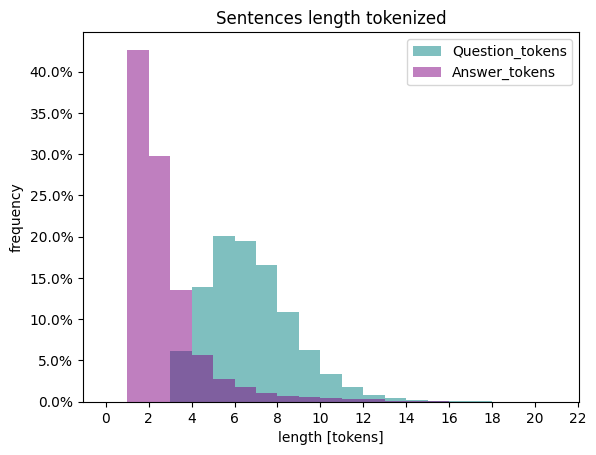

In [39]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [40]:
train_df_final.shape

(25697, 4)

In [41]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.25
	         median: 6.00
	         minimum: 3
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.26
	         median: 2.00
	         minimum: 1
	         maximum: 20)


In [42]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


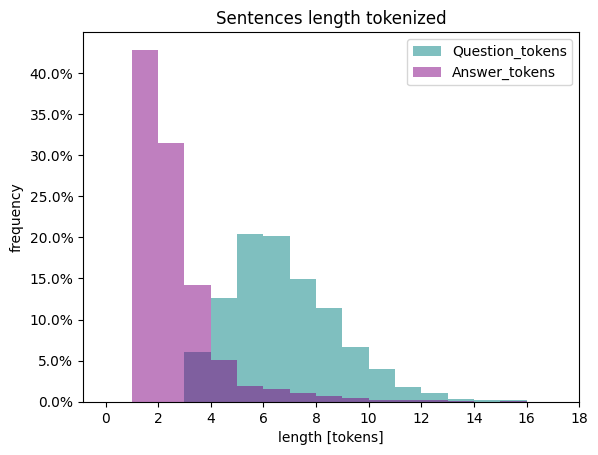

In [43]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [44]:
test_df_final.shape

(2579, 4)

In [45]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.32
	         median: 6.00
	         minimum: 3
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.14
	         median: 2.00
	         minimum: 1
	         maximum: 18)


### Remove long outliers: long sentences that occure rarely

In [46]:
# keeping only the 95% of the data
cutoff = 95

In [47]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [48]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [49]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [50]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.06
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.98
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [50]:
# to simplify I'm using the same thresholds for the test set

In [51]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [52]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.13
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.93
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [53]:
train_df_final.shape, test_df_final.shape

((23829, 4), (2409, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [54]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [55]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [56]:
len(train_pairs_final), len(test_pairs_final)

(23829, 2409)

In [57]:
def to_tensor_new(vocab, tokens, seq_len):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    If too short, it uses padding at the beginning of the sentence as suggested by the mentor.'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    #padded = [vocab.word2index['PAD']] * (seq_len-len(tokens)) + [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']]

    padded = [[vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens))]
    
    tensor = torch.Tensor(padded).long().view(-1,1)
    
    return tensor

In [58]:
Pair = namedtuple('Pair', ['question', 'answer'])
def get_tensor_pairs_from_df(df, cols, q_vocab, q_max_len, a_vocab, a_max_len):
    '''returns a list of named tuples (question, answer)'''
    dicts = []
    for col in cols:
        dicts.append(df[col].to_dict().values())
    
    return [Pair(to_tensor_new(q_vocab, q, q_max_len), to_tensor_new(a_vocab, a, a_max_len)) for q, a in zip(*dicts)]

In [59]:
train_tensor_pairs_final = get_tensor_pairs_from_df(train_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX)

In [60]:
train_tensor_pairs_final[777]

Pair(question=tensor([[   1],
        [   3],
        [ 519],
        [1536],
        [2589],
        [2590],
        [ 324],
        [   2],
        [   0],
        [   0],
        [   0],
        [   0]]), answer=tensor([[   1],
        [1947],
        [1948],
        [1949],
        [   2],
        [   0],
        [   0],
        [   0]]))

In [61]:
test_tensor_pairs_final = get_tensor_pairs_from_df(test_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX)

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



# TRYING A MULTI-LAYER LSTM WITH DROPOUT

In [62]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, embedding_size, hidden_size, n_layers, dropout = 0):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(self.input_size, self.embedding_size)#.to(device)
        
        # The LSTM is our last cell because it produces the hidden state        
        
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers, dropout=dropout)#.to(device)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, hidden, cell_state):
        
        embedded = self.dropout(self.embedding(x))

        
        #x = x.view(1, 1, -1)
        
        #x = x.view(x.shape[0], 1, -1)
        
        #x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))

        outputs, (hidden, cell_state) = self.lstm(embedded)

        return hidden, cell_state

class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    #def __init__(self, hidden_size, output_size, embedding_size, dropout = 0):
    def __init__(self, output_size, embedding_size, hidden_size, n_layers, dropout = 0):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        #self.dropout = dropout

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)

        #self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, dropout = self.dropout)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, n_layers, dropout=dropout)
        
        # The LSTM produces an output by passing the hidden state to the   Linear layer
    
        self.fc_out = nn.Linear(self.hidden_size, self.output_size)

        self.dropout = nn.Dropout(dropout)
        
        #self.softmax = nn.LogSoftmax(dim= 1)     

    def forward(self, x, hidden, cell_state):

        input = x.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))
        
        #x = x.view(1, 1, -1)
        output, (hidden, cell_state) = self.lstm(embedded, (hidden, cell_state))
        
        #x = self.softmax(self.fc(x[0]))

        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell_state

    
class Seq2Seq(nn.Module):

    #def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
    #def __init__(self, input_size, hidden_size, embedding_size, output_size, dropout, device):    
    #def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    

    def __init__(self, encoder, decoder, device):
        
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        #self.input_size = input_size
        #self.hidden_size = hidden_size
        #self.embedding_size = embedding_size
        #self.output_size = output_size
        #self.dropout = dropout

        assert encoder.hidden_size == decoder.hidden_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Number of layers of encoder and decoder must be equal!"
        
        
        #self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size, self.dropout).to(device)
        #self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size, self.dropout).to(device)
        #self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        #self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
        #self.device = device
        
    #def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_size

        # empty tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        enc_hidden = torch.zeros([1, 1, self.encoder.hidden_size]).to(self.device) 
        enc_cell_state = torch.zeros([1, 1, self.encoder.hidden_size]).to(self.device)

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell_state = self.encoder(src, enc_hidden, enc_cell_state)

        # first input to the decoder is the <SOS> token - check if that is true!
        input = trg[0,:]


        for t in range(1, trg_len):

            # insert inpu token embedding, previous hidden and previous cell state
            # outputs: predictions, new hidden and cell states
            output, hidden, cell_state = self.decoder(input, hidden, cell_state)

            # place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # decide if use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

             # get the highest predicted token from our predictions
            top1 = output.argmax(1)

            # if teacher forcing, use actual next token as next input
            # otherwise use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

### Model parameters

In [120]:
input_dim = Q_vocab.n_words
output_dim = A_vocab.n_words

enc_emb_dim = 256
dec_emb_dim = 256

hid_dim = 256

n_layers = 4

enc_dropout = 0.2
dec_dropout = 0.2

learning_rate = 0.01

num_epochs = 25

In [121]:
enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)

In [122]:
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

embedding_dim = 256
hidden_size = 256
dropout = 0.5

### Hyperparameters

learning_rate = 0.005
num_epochs = 10

### Model

In [152]:
#seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, dropout=dropout, device=device)
#seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [123]:
model = Seq2Seq(enc, dec, device).to(device)

In [124]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18285, 256)
    (lstm): LSTM(256, 256, num_layers=4, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(23838, 256)
    (lstm): LSTM(256, 256, num_layers=4, dropout=0.2)
    (fc_out): Linear(in_features=256, out_features=23838, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [125]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18285, 256)
    (lstm): LSTM(256, 256, num_layers=4, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(23838, 256)
    (lstm): LSTM(256, 256, num_layers=4, dropout=0.2)
    (fc_out): Linear(in_features=256, out_features=23838, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [126]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,120,542 trainable parameters


In [157]:
#seq2seq = seq2seq.to(device)

### Optimizer and loss function

In [127]:
from torch import optim
import torch.nn as nn

optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

In [128]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [111]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

In [80]:
Q_vocab.word2index['PAD']

0

def to_tensor_modified(vocab, tokens, seq_len, device):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    If too short, it uses padding at the end of the sentence'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    padded = [[vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens))]
    
    tensor = torch.Tensor(padded).long().to(device).view(-1,1)
    
    return tensor

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [129]:
def train(model, iterator, optimizer, criterion, clip, print_every = 1000):
    model.train()

    epoch_loss = 0

    counter = 0

    for i, batch in enumerate(iterator):
        src = batch.question.to(device)
        trg = batch.answer.to(device)

        #src_tensor = to_tensor_modified(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        #trg_tensor = to_tensor_modified(vocab=A_vocab, tokens=trg, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)
        
        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        counter += 1
        
        if counter % print_every == 0:
            print(f'training loss: {epoch_loss/counter}')
    
    return epoch_loss / len(iterator)
    

In [130]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):
            
            src = batch.question.to(device)
            trg = batch.answer.to(device)
    
            output = model(src, trg, 0) # turn off teacher forcing
    
            output_dim = output.shape[-1]
    
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
    
            loss = criterion(output, trg)
    
            epoch_loss += loss.item()
    
            
        
    return epoch_loss / len(iterator)

In [131]:
N_EPOCHS = 25
CLIP = 1

In [132]:
import matplotlib.pyplot as plt

In [133]:
total_train_loss = []
total_test_loss = []

In [ ]:
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_tensor_pairs_final, optimizer, criterion, CLIP)
    test_loss = evaluate(model, test_tensor_pairs_final, criterion)

    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)

    print(f'Epoch {epoch+1}, train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')

training loss: 8.17824058842659
training loss: 8.523263194084167
training loss: 8.613524945219357
training loss: 8.65134888100624
training loss: 8.615575782060624
training loss: 8.674214493711789
training loss: 8.711083892737117
training loss: 8.744592888772488
training loss: 8.79911899014314
training loss: 8.909669956958293
training loss: 8.980960205457427
training loss: 8.989273568163316
training loss: 9.005128586163888
training loss: 8.991368658653327
training loss: 8.9795694693168
training loss: 8.956290279947222
training loss: 8.940956131311024
training loss: 8.907966500851844
training loss: 8.867435367232876
training loss: 8.83633751321435
training loss: 8.80910579842613
training loss: 8.788326866426251
training loss: 8.762236299996792
Epoch 1, train loss: 8.755, test loss: 8.543
training loss: 8.672127496480941
training loss: 8.50803759920597
training loss: 8.44315274631977
training loss: 8.407963800013066
training loss: 8.338656292915344
training loss: 8.295339603741963
trainin

Text(0, 0.5, 'loss')

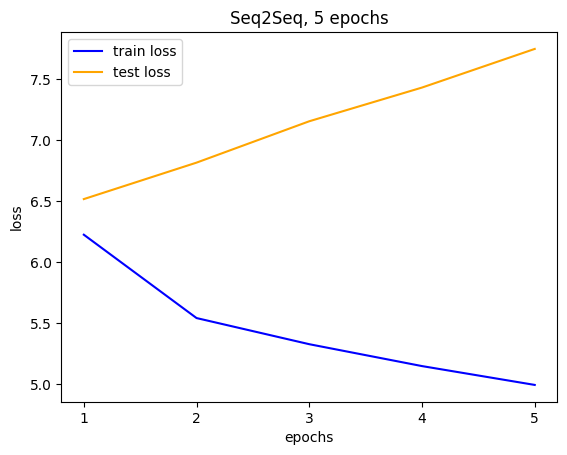

In [125]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

In [229]:
total_train_loss = []
total_test_loss = []

In [230]:
def train(model, pairs, optimizer, criterion, device, print_every = 1000):
    model.train()  # Set the model to training mode
    
    total_loss = 0

    count = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
        count += 1 
    
        if count % print_every == 0:
            print(f'Loss {total_loss/count}')
    
    return total_loss / len(pairs)

In [231]:
def evaluate(model, pairs, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for pair in pairs:
            
            src = pair.question
            tgt = pair.answer
            
            src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
            tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

            
            total_loss += loss.item()
        
    return total_loss / len(pairs)

In [232]:
import matplotlib.pyplot as plt

In [233]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    test_loss = evaluate(seq2seq, test_pairs_final, criterion, device)    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



Loss 6.598265001296997
Loss 6.00891935133934
Loss 5.770370157400767
Loss 5.645824918329716
Loss 5.536176259994507
Loss 5.4576265561183295
Loss 5.393392550230026
Loss 5.342395387381315
Loss 5.296035670571857
Loss 5.256664577746391
Loss 5.223029337070205
Loss 5.190010191490253
Loss 5.152424820212217
Loss 5.120430512377194
Loss 5.088948726598422
Loss 5.065876370660961
Loss 5.047753107645932
Loss 5.022623438000679
Loss 5.005083603940512
Loss 4.982833900004625
Loss 4.963578401701791
Loss 4.947249743900516
Loss 4.930479061375493
Loss 4.913348267580072
Loss 4.898897460799217
Loss 4.883432724815148
Loss 4.867586285939923
Loss 4.85496627974936
Loss 4.841263163702242
Loss 4.829055050702889
Loss 4.817785317782433
Loss 4.80572670994699
Loss 4.797464317426537
Loss 4.78335125289945
Loss 4.772629938898768
Loss 4.761856510794825
Loss 4.754160509802199
Loss 4.7439844267901625
Loss 4.733330202356363
Loss 4.726135592579841
Loss 4.71768442690954
Loss 4.710878596598194
Loss 4.7039295907990875
Loss 4.697628

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

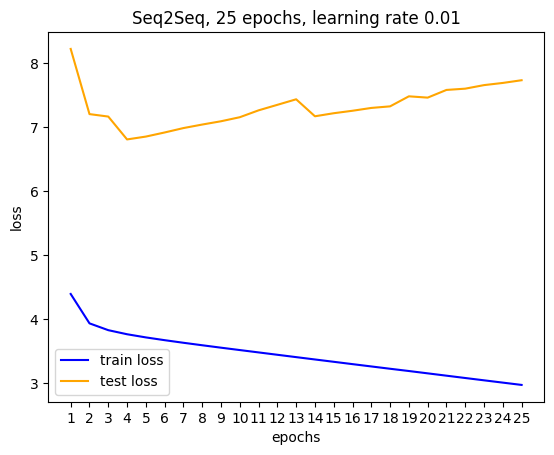

In [148]:
fig, ax = plt.subplots()
ax.plot(range(1, num_epochs+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, num_epochs+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {num_epochs} epochs, learning rate {learning_rate}')
ax.set_xticks(range(1, num_epochs+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

In [ ]:
https://jaketae.github.io/study/seq2seq/